### Rewrite dlnd_project2 in kur
- [original project_2 code](http://nbviewer.jupyter.org/github/EmbraceLife/image_classification_dlnd2/blob/master/cnn_cifar10.ipynb#annotations:5YK7tv1dEealzwMjXZx4WQ) in tensorflow
- [detailed outline](https://github.com/EmbraceLife/image_classification_dlnd2/blob/master/outline.md) of the original code
- kur code to replicate the original code is below

In [1]:
!kur --version

Kur, by Deepgram -- deep learning made easy
Version: 0.3.0
Homepage: https://kur.deepgram.com


In [12]:
%%writefile dlnd_p2.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           
                        # I am tempting to read supplier source code to understand better how to use 
                        # each supplier (I see a few available, csv, pickle), do you think 
                        # it is a good idea to spend time on?  #################################################

                        
  # Backend to use                                      
  backend:
    name: keras         # how many backend does kur have, and what different do they make? ##################### 
                        # some complaint about keras performance, do you think it is an issue? #################

  # Hyperparameters
  cnn:
    kernels: 20
    size: [5, 5]
    strides: [2, 2]                

  pool:
    size: [2,2]
    strides: [2,2]
    type: "max"                         

model:
  - input: images                       
  - convolution:                        
      kernels: "{{cnn.kernels}}"
      size: "{{cnn.size}}"
      strides: "{{ cnn.strides }}"
  - activation: relu
  - pool:
      size: "{{pool.size}}"
      strides: "{{pool.strides}}"
      type: "{{pool.type}}"             
  - flatten:
  - dense: 15                           
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      # only use dataset part 1 to train
  provider:
    batch_size: 128
    num_batches: 1000                   # the entire part 1 will be used
  log: t3/cifar-log                   
  epochs: 20
  weights:
    initial: t3/cifar.best.valid.w    # do you think is it essential to implement weight visualization? #############
    best: t3/cifar.best.train.w       # visualizing weights on different layers is used in explaining cnn on image###
    last: t3/cifar.last.w             # or is it not important for help experimenting on models #####################

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          # only use dataset part 5 as validation set
  provider:
    num_batches: 50                      # the project 2 only used 5000 data points as validation set
  weights: t3/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t3/cifar.best.valid.w
  provider:
    num_batches: 1000                     # the entire part test will be used

evaluate:
  <<: *test
  destination: t3/cifar.results.pkl

loss:
  - target: labels                        # in the project: training loss and valid_accuracy are printed #############
    name: categorical_crossentropy        # this should be a matter of personal taste, won't really affect anything##
...


Overwriting dlnd_p2.yml


In [13]:
%pwd

'/Users/Natsume/Downloads/kur_road'

In [14]:
%ls

Kur_Road.ipynb       dlnd_p2_dropout.yml  t1/
cifar-log/           dlnd_p2_kur.ipynb    t2/
dlnd_p2.yml          kur/                 t3/


In [15]:
!kur -v train dlnd_p2.yml

[INFO 2017-02-28 22:28:48,972 kur.kurfile:638] Parsing source: dlnd_p2.yml, included by top-level.
[INFO 2017-02-28 22:28:48,989 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-28 22:28:49,038 kur.loggers.binary_logger:87] Log does not exist. Creating path: t3/cifar-log
[INFO 2017-02-28 22:28:56,014 kur.providers.batch_provider:54] Batch size set to: 128
[INFO 2017-02-28 22:28:56,014 kur.providers.batch_provider:60] Maximum number of batches set to: 1000
[INFO 2017-02-28 22:29:02,413 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-28 22:29:02,413 kur.providers.batch_provider:60] Maximum number of batches set to: 50
[INFO 2017-02-28 22:29:02,414 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-28 22:29:02,414 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-28 22:29:02,414 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-28 22:29:03,578 kur.backend.keras_backend:191] Keras is loaded. The backe

In [22]:
# %cd t3/
!ls cifar-log

training_loss_labels   validation_loss_labels
training_loss_total    validation_loss_total


In [23]:
from kur.loggers import BinaryLogger
training_loss = BinaryLogger.load_column('cifar-log', 'training_loss_total') 
validation_loss = BinaryLogger.load_column('cifar-log', 'validation_loss_total') 
 
training_loss

array([ 2.0347259 ,  1.6929394 ,  1.54147506,  1.44420362,  1.3758949 ,
        1.31863678,  1.26508343,  1.2262063 ,  1.18933189,  1.15463436,
        1.12429321,  1.09335482,  1.06431651,  1.04932415,  1.02948546,
        0.99968618,  0.98606402,  0.9677121 ,  0.96266526,  0.93041307], dtype=float32)

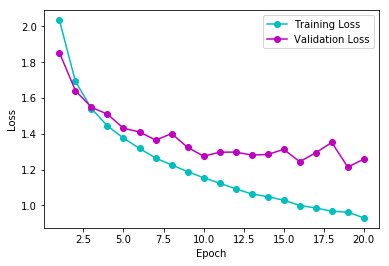

In [24]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
epoch = list(range(1, 1+len(training_loss)))
t_line, = plt.plot(epoch, training_loss, 'co-', label='Training Loss')
v_line, = plt.plot(epoch, validation_loss, 'mo-', label='Validation Loss')
plt.legend(handles=[t_line, v_line])
plt.show()

In [4]:
%%writefile dlnd_p2_dropout.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           # if kur does not have normalization or one-hot-encoding, ##################
                            # without normalization and one-hot-encoding, the performance will be hurt, right? ####
  # Backend to use                                      
  backend:
    name: keras

  # Hyperparameters
  cnn:
    kernels: 20
    size: [5, 5]
    strides: [2, 2]                

  pool:
    size: [2,2]
    strides: [2,2]
    type: max                         # must use a string here, {max} won't work, doc didn't say it #############

model:
  - input: images                       # images are normalized from 0 to 1, labels are one-hot-encoding ##########
  - convolution:                        # does kur do normalize and one-hot-encoding under the hood? ##############
      kernels: "{{cnn.kernels}}"
      size: "{{cnn.size}}"
      strides: "{{ cnn.strides }}"
  - activation: relu
  - pool:
      size: "{{pool.size}}"
      strides: "{{pool.strides}}"
      type: "{{pool.type}}"             
  - flatten:
  - dense: 15                           # p2 want a dropout applied here, but kur does not have yet?? ############
  - dropout: 0.25
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      # only use dataset part 1 to train
  provider:
    batch_size: 128
    num_batches: 1000                   # the entire part 1 will be used
  log: t1_dp0.25/cifar-log                   
  epochs: 20
  weights:
    initial: t1_dp0.25/cifar.best.valid.w    
    best: t1_dp0.25/cifar.best.train.w
    last: t1_dp0.25/cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          # only use dataset part 5 as validation set
  provider:
    batch_size: 128
    num_batches: 50                      # the project 2 only used 5000 data points as validation set
  weights: t1_dp0.25/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t1_dp0.25/cifar.best.valid.w
  provider:
    batch_size: 128
    num_batches: 1000                     # the entire part test will be used

evaluate:
  <<: *test
  destination: t1_dp0.25/cifar.results.pkl

loss:
  - target: labels                        # in the project: training loss and valid_accuracy are printed #############
    name: categorical_crossentropy        # this should be a matter of personal taste, won't really affect anything##
...


Overwriting dlnd_p2_dropout.yml


In [5]:
!kur -v train dlnd_p2_dropout.yml

[INFO 2017-03-01 07:34:45,517 kur.kurfile:699] Parsing source: dlnd_p2_dropout.yml, included by top-level.
[INFO 2017-03-01 07:34:45,533 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-01 07:34:45,558 kur.loggers.binary_logger:107] Log does not exist. Creating path: t1_dp0.25/cifar-log
[INFO 2017-03-01 07:34:58,394 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-01 07:34:58,394 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-01 07:34:58,394 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-01 07:34:59,341 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-01 07:34:59,341 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-01 07:34:59,342 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-01 07:34:59,342 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-01 07:35:00,404 kur.model.model:284] Model inputs:  images
[INFO 2017-03-01

In [7]:
# %cd t1_dp0.25/
!ls cifar-log

batch_loss_batch       training_loss_batch    validation_loss_labels
batch_loss_labels      training_loss_labels   validation_loss_total
batch_loss_total       training_loss_total
summary.yml            validation_loss_batch


In [9]:
%pycat summary.yml

ERROR:root:Cell magic `%%pycat` not found (But line magic `%pycat` exists, did you mean that instead?).


In [10]:
from kur.loggers import BinaryLogger
training_loss = BinaryLogger.load_column('cifar-log', 'training_loss_total') 
validation_loss = BinaryLogger.load_column('cifar-log', 'validation_loss_total') 
 
training_loss

array([ 2.08002758,  1.80103576,  1.64649773,  1.53694201,  1.47005808,
        1.4060986 ,  1.37083662,  1.32995439,  1.3027122 ,  1.29357958,
        1.25282907,  1.23259354,  1.21278262,  1.19201612,  1.17865086,
        1.15514135,  1.14136755,  1.1234889 ,  1.1214298 ,  1.10675633], dtype=float32)

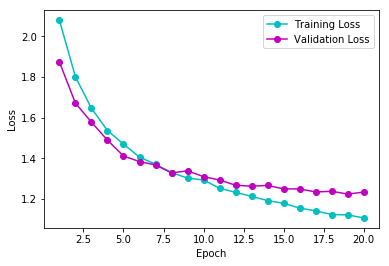

In [11]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
epoch = list(range(1, 1+len(training_loss)))
t_line, = plt.plot(epoch, training_loss, 'co-', label='Training Loss')
v_line, = plt.plot(epoch, validation_loss, 'mo-', label='Validation Loss')
plt.legend(handles=[t_line, v_line])
plt.show()

## Learning Tasks on Kur

**Task1: Split kurfile**
- split kurfile into fluid and default parts
- default part remain constant
- fluid part will be easy to change constantly for experimenting

**Solution1: Split kurfile**
- layer parameters will keep changing
- file path will keep changing
- data parts for train and validate will change
- batch_size and num_batches will change
- hyperparameters like learning rate will change

**Create a dlnd_p2_defaults.yml**

In [4]:
%%writefile dlnd_p2_defaults.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"  
    
  # Backend to use                                      
  backend:
    name: keras    
    
model:                             # there should be loop design for model structure flexibility
  - input: images                       
  - convolution:                        
      kernels: "{{cnn.kernels}}"
      size: "{{cnn.size}}"
      strides: "{{ cnn.strides }}"
  - activation: relu
  - pool:
      size: "{{pool.size}}"
      strides: "{{pool.strides}}"
      type: "{{pool.type}}"             
  - flatten:
  - dense: "{{dense.out1}}"       # 15                    
  - dense: "{{dense.out2}}"       # 10
  - activation: softmax
    name: labels    
    

    
train:
  data:
    - cifar:
        <<: *cifar
        parts: "{{part.train}}"               # only use dataset part 1 to train
  provider:
    batch_size: "{{batch_size.train}}"        # 128
    num_batches: "{{num_batches.train}}"      # total batch is less than 100, so use 1000 is to select all       #####     
    randomize: True                           # Importance: when train on small sample we still want weights to have 
                                              # generalize power. model overfit by memorizing the same data points#### 

  log: "{{path.log}}"                         # t1_dp0.25/cifar-log                   
  epochs: "{{num_epochs}}"                    # 20
  weights:
    initial: "{{path.initial_w}}"             # t1_dp0.25/cifar.best.valid.w    
    best: "{{path.best_train_w}}"             # t1_dp0.25/cifar.best.train.w
    last: "{{path.last_w}}"                   # t1_dp0.25/cifar.last.w

  optimizer:
    name: adam
    learning_rate: "{{learning_rate}}"        # 0.001       


validate:
  data:
    - cifar:
       <<: *cifar
       parts: "{{part.valid}}"                # only use dataset part 5 as validation set
  provider:
    batch_size: "{{batch_size.valid}}"        # same as training, 128
    num_batches: "{{num_batches.valid}}"      # the project 2 only used 5000 data points as validation set, so 50 
  weights: "{{path.best_valid_w}}"            # t1_dp0.25/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: "{{path.best_valid_w}}"            # t1_dp0.25/cifar.best.valid.w
  provider:
    batch_size: "{{batch_size.test}}"         # same as training, 128
    num_batches: "{{num_batches.test}}"      # the entire part test will be used, set it 1000

evaluate:
  <<: *test
  destination: "{{path.result}}"              # t1_dp0.25/cifar.results.pkl

loss:
  - target: labels                       
    name: categorical_crossentropy        

...


Overwriting dlnd_p2_defaults.yml


**Create dlnd_p2_fluid.yml**

In [5]:
%%writefile dlnd_p2_fluid.yml

---
settings: 
  cnn: 
    kernels: 20              # why cannot use [20]? what if there are 2 conv layers [20, 30]
    size: [5,5]  
    strides: [2,2]
  pool: 
    size: [2,2]
    strides: [2,2]
    type: "max"  
  dense: 
    out1: 15
    out2: 10
  part: 
    train: 1
    valid: 5
    test: test
  batch_size: 
    train: 128
    valid: 128
    test: 128
  num_batches: 
    train:                # 1000 and nothing here both refer to all the batches? ###########################
    valid: 50
    test: 
  path: 
    log: t1_dp0.25/cifar-log
    initial_w: t1_dp0.25/cifar.best.valid.w
    best_train_w: t1_dp0.25/cifar.best.train.w
    last_w: t1_dp0.25/cifar.last.w
    best_valid_w: t1_dp0.25/cifar.best.valid.w
    result: t1_dp0.25/cifar.results.pkl
  learning_rate: 0.001
  num_epochs: 1


include: dlnd_p2_defaults.yml  # to define default setting
...

Overwriting dlnd_p2_fluid.yml


- is grid search or random search for best parameters or hyperparameter is a feature kur want to implement?
- automatically searching for best parameters like gradient descent search for local or gloabl optimal is a nice thing to have right? 

In [6]:
!kur -vv train dlnd_p2_fluid.yml

[INFO 2017-03-01 15:24:19,985 kur.kurfile:699] Parsing source: dlnd_p2_fluid.yml, included by top-level.
[INFO 2017-03-01 15:24:19,996 kur.kurfile:699] Parsing source: dlnd_p2_defaults.yml, included by dlnd_p2_fluid.yml.
[INFO 2017-03-01 15:24:20,010 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-01 15:24:20,010 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-01 15:24:20,016 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-01 15:24:20,023 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-01 15:24:20,028 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-01 15:24:20,033 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-01 15:24:20,039 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: images
[DEBUG 2017-03-01 15:24:20,040 kur.containers.layers.placeholder:97] Placeholder "images" has a deferred shape.
[DEBUG 2017-03-01 15:24:20,050 kur.kurfile:784] Parsing Kurfile section: loss
[INFO 

## Simplify Kurfile 

In [3]:
%%writefile dlnd_p2_dropout.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           # if kur does not have normalization or one-hot-encoding, ##################
                            # without normalization and one-hot-encoding, the performance will be hurt, right? ####
  # Backend to use                                      
  backend:
    name: keras

  # Hyperparameters
#   cnn:
#     kernels: 20
#     size: [5, 5]
#     strides: [2, 2]                

#   pool:
#     size: [2,2]
#     strides: [2,2]
#     type: max                         

model:
  - input: images                       
  - convolution:                       
      kernels: 20
      size: [5, 5]
      strides: [2,2]
  - activation: relu
  - pool:
      size: [2,2]
      strides: [2,2]
      type: max
  - flatten:
  - dense: 15                           
  - dropout: 0.25
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      
  provider: &provider
    batch_size: 128
    num_batches: 3                        # use all batches
    randomize: True
  log: t1_dp0.25/cifar-log                   
  epochs: 1
  weights:
    initial: t1_dp0.25/cifar.best.valid.w    
    best: t1_dp0.25/cifar.best.train.w
    last: t1_dp0.25/cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          
  provider: 
    <<: *provider       # can I do this? ##########
    num_batches: 2     # override num_batches to be 50 while keep batch_size and randomize as 128 and True ####
  weights: t1_dp0.25/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t1_dp0.25/cifar.best.valid.w
  provider: 
    <<: *provider
    randomize: False


evaluate:
  <<: *test
  destination: t1_dp0.25/cifar.results.pkl

loss:
  - target: labels                        # in the project: training loss and valid_accuracy are printed #############
    name: categorical_crossentropy        # this should be a matter of personal taste, won't really affect anything##
...


Overwriting dlnd_p2_dropout.yml


In [4]:
!kur -vv train dlnd_p2_dropout.yml

[INFO 2017-03-02 20:31:03,897 kur.kurfile:699] Parsing source: dlnd_p2_dropout.yml, included by top-level.
[INFO 2017-03-02 20:31:03,910 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-02 20:31:03,910 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-02 20:31:03,914 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-02 20:31:03,917 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-02 20:31:03,919 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-02 20:31:03,921 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-02 20:31:03,925 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: images
[DEBUG 2017-03-02 20:31:03,925 kur.containers.layers.placeholder:97] Placeholder "images" has a deferred shape.
[DEBUG 2017-03-02 20:31:03,927 kur.kurfile:784] Parsing Kurfile section: loss
[INFO 2017-03-02 20:31:03,929 kur.loggers.binary_logger:107] Log does not exist. Creating path: t1_dp0.25/cifar-log
[DEB

In [1]:
%%writefile dlnd_p2_dropout.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           # if kur does not have normalization or one-hot-encoding, ##################
                            # without normalization and one-hot-encoding, the performance will be hurt, right? ####
  # Backend to use                                      
  backend:
    name: keras

  # Hyperparameters
#   cnn:
#     kernels: 20
#     size: [5, 5]
#     strides: [2, 2]                

#   pool:
#     size: [2,2]
#     strides: [2,2]
#     type: max                         

model:
  - input: images                       
  - convolution:                       
      kernels: 20
      size: [5, 5]
      strides: [2,2]
  - activation: relu
  - pool:
      size: [2,2]
      strides: [2,2]
      type: max
  - flatten:
  - dense: 15                           
  - dropout: 0.25
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      
  provider: &provider
    batch_size: 128
    num_batches: 1000                        # use all batches
    randomize: True
  log: t1_dp0.25/cifar-log                   
  epochs: 20
  weights:
    initial: t1_dp0.25/cifar.best.valid.w    
    best: t1_dp0.25/cifar.best.train.w
    last: t1_dp0.25/cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001
        
    #  hooks:
    #    - plot: loss.png

  hooks:
    - plot:
        loss_per_batch: t1_dp0.25/loss1.png
        loss_per_time: t1_dp0.25/loss2.png
        throughput_per_time: t1_dp0.25/loss3.png

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          
  provider: 
    <<: *provider       
    num_batches: 50     
  weights: t1_dp0.25/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t1_dp0.25/cifar.best.valid.w
  provider: 
    <<: *provider
    randomize: False


evaluate:
  <<: *test
  destination: t1_dp0.25/cifar.results.pkl

loss:
  - target: labels                        
    name: categorical_crossentropy        
        

...


Overwriting dlnd_p2_dropout.yml


In [3]:
!kur -v train dlnd_p2_dropout.yml

[INFO 2017-03-02 22:41:19,495 kur.kurfile:699] Parsing source: dlnd_p2_dropout.yml, included by top-level.
[INFO 2017-03-02 22:41:19,511 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-02 22:41:19,532 kur.loggers.binary_logger:107] Log does not exist. Creating path: t1_dp0.25/cifar-log
[INFO 2017-03-02 22:41:36,185 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-02 22:41:36,185 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-02 22:41:36,185 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-02 22:41:37,112 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-02 22:41:37,113 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-02 22:41:37,113 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-02 22:41:37,113 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-02 22:41:38,321 kur.model.model:284] Model inputs:  images
[INFO 2017-03-02

In [14]:
from IPython.display import Image

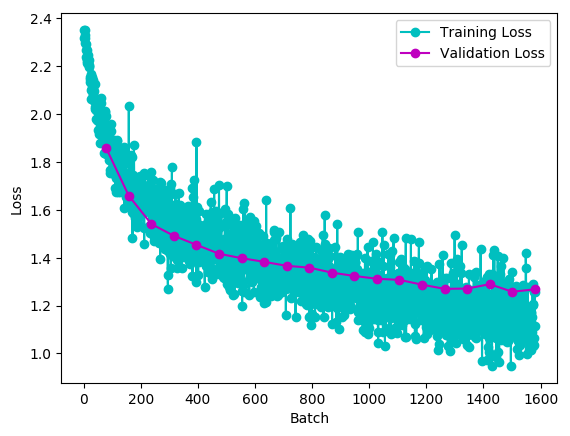

In [22]:
Image(width = 500, height=200, retina= True, filename='t1_dp0.25/loss1.png')

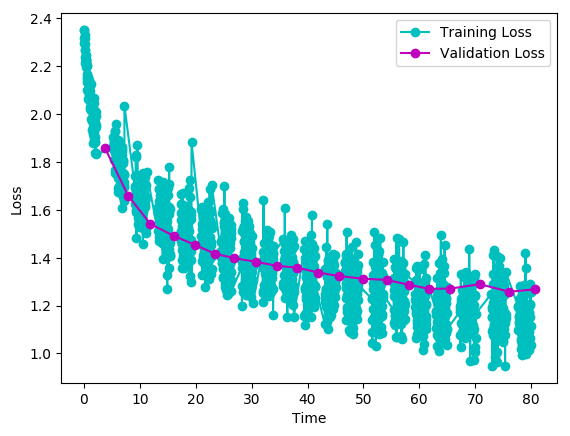

In [24]:
Image(width = 500, height=200, retina= True, filename='t1_dp0.25/loss2.png')

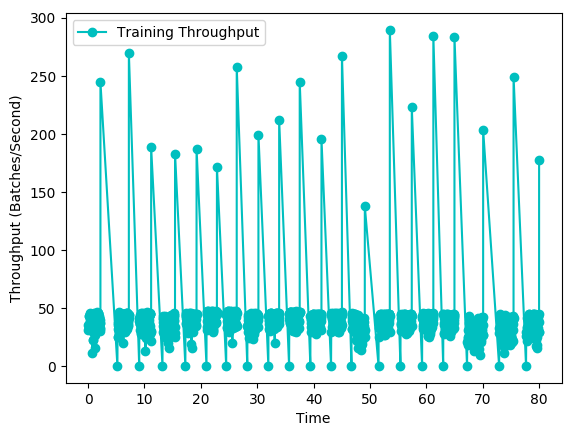

In [27]:
Image(width = 500, height=500, retina= True, filename = 't1_dp0.25/loss3.png')

In [4]:
!kur dump dlnd_p2_dropout.yml

{
    "evaluate": {
        "data": [
            {
                "cifar": {
                    "checksum": "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce",
                    "parts": "test",
                    "path": "~/kur",
                    "url": "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
                }
            }
        ],
        "destination": "t1_dp0.25/cifar.results.pkl",
        "provider": {
            "batch_size": 128,
            "num_batches": 1000,
            "randomize": false
        },
        "weights": "t1_dp0.25/cifar.best.valid.w"
    },
    "evaluation": {
        "data": [
            {
                "cifar": {
                    "checksum": "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce",
                    "parts": "test",
                    "path": "~/kur",
                    "url": "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
                }
            }
        ],